In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import pandas as pd
from functools import partial
from atom3d.util import metrics
from collections import defaultdict
import collections as col

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

In [3]:
oak_dir = '/oak/stanford/groups/rbaltman'
results_dir = os.path.join(oak_dir, 'protein_data_bias/results/Task2')

In [4]:
def to_df(dic):
    df = pd.DataFrame(dic)
    df.true = pd.to_numeric(df.true)
    df.pred = pd.to_numeric(df.pred)
    return df

In [5]:
original_res = to_df(torch.load(os.path.join(results_dir, 'out-casp_mixed_2.best.test.pt'), map_location='cpu'))
new_res = to_df(torch.load(os.path.join(results_dir, 'out-casp_xray_only_2.best.test.pt'), map_location='cpu'))

In [6]:
pd.DataFrame(original_res)

,target,true,pred
0,T0769,0.4665,0.675135
1,T0769,0.4777,0.702761
2,T0769,0.4732,0.673238
3,T0769,0.4732,0.623604
4,T0769,0.4621,0.648093
...,...,...,...
4978,T1016,0.7859,0.948790
4979,T1016,0.7760,0.937552
4980,T1016,0.7822,0.927612
4981,T1016,0.7834,0.954377


In [7]:
def get_metrics():
    def _correlation(metric, targets, predict, ids=None, glob=True):
        if glob: return metric(targets, predict)
        _targets, _predict = defaultdict(list), defaultdict(list)
        for _t, _p, _id in zip(targets, predict, ids):
            _targets[_id].append(_t)
            _predict[_id].append(_p)
        return np.mean([metric(_targets[_id], _predict[_id]) for _id in _targets])
        
    correlations = {
        'pearson': partial(_correlation, metrics.pearson),
        'kendall': partial(_correlation, metrics.kendall),
        'spearman': partial(_correlation, metrics.spearman)
    }
    mean_correlations = {f'mean {k}' : partial(v, glob=False) \
                            for k, v in correlations.items()}
    
    return {**correlations, **mean_correlations}

In [8]:
def evaluate(res):
    ids = res.target
    y_true = res.true
    y_pred = res.pred
    metrics = get_metrics()
    results = {}
    for name, func in metrics.items():
        func = partial(func, ids=ids)
        value = func(y_true, y_pred)
#         print(f"{name}: {value}")
        results[name] = value
    return results

In [9]:
evaluate(original_res)

{'pearson': 0.7362647678821617,
 'kendall': 0.5297825123567331,
 'spearman': 0.7261046776411598,
 'mean pearson': 0.6119055687680736,
 'mean kendall': 0.4214844426326394,
 'mean spearman': 0.573822905238378}

In [10]:
evaluate(new_res)

{'pearson': 0.6409812518695452,
 'kendall': 0.44582780541213024,
 'spearman': 0.6217184137134022,
 'mean pearson': 0.556914880784676,
 'mean kendall': 0.3713833805472927,
 'mean spearman': 0.5094163383781743}

In [11]:
all_res = pd.concat([original_res,  new_res])
all_res['split'] = ['Train: Mixed']*len(original_res) + ['Train: X-ray']*len(new_res) 

In [12]:
all_res.head()

,target,true,pred,split
0,T0769,0.4665,0.675135,Train: Mixed
1,T0769,0.4777,0.702761,Train: Mixed
2,T0769,0.4732,0.673238,Train: Mixed
3,T0769,0.4732,0.623604,Train: Mixed
4,T0769,0.4621,0.648093,Train: Mixed


In [13]:
all_res.target.unique()

array(['T0769', 'T0773', 'T0853', 'T0855', 'T0857', 'T0865', 'T0902',
       'T0918', 'T0950', 'T0951', 'T0953s1', 'T0953s2', 'T0954', 'T0955',
       'T0957s1', 'T0957s2', 'T0958', 'T0960', 'T0963', 'T0966',
       'T0968s1', 'T0968s2', 'T1003', 'T1005', 'T1008', 'T1009', 'T1011',
       'T1016'], dtype=object)

In [14]:
natives_pdb = pd.read_csv('natives_pdb.csv')
target_method_dict = dict(zip(natives_pdb.target_id, natives_pdb['EXPERIMENT TYPE']))
target_casp_dict = dict(zip(natives_pdb.target_id, natives_pdb['casp_ed']))

In [15]:
all_res['method'] = all_res.target.apply(lambda x: target_method_dict[x])

In [16]:
all_res['casp'] = all_res.target.apply(lambda x: target_casp_dict[x])

In [17]:
all_res.head()

,target,true,pred,split,method,casp
0,T0769,0.4665,0.675135,Train: Mixed,SOLUTION NMR,11
1,T0769,0.4777,0.702761,Train: Mixed,SOLUTION NMR,11
2,T0769,0.4732,0.673238,Train: Mixed,SOLUTION NMR,11
3,T0769,0.4732,0.623604,Train: Mixed,SOLUTION NMR,11
4,T0769,0.4621,0.648093,Train: Mixed,SOLUTION NMR,11


In [18]:
col.Counter(all_res.method.tolist())

Counter({'SOLUTION NMR': 3016,
         'ELECTRON MICROSCOPY': 618,
         'X-RAY DIFFRACTION': 6332})

In [19]:
all_res = all_res[all_res['method'].isin(['X-RAY DIFFRACTION', 'SOLUTION NMR', 'ELECTRON MICROSCOPY'])]

In [20]:
all_res.groupby('method').count()

,target,true,pred,split,casp
method,,,,,
ELECTRON MICROSCOPY,618,618,618,618,618
SOLUTION NMR,3016,3016,3016,3016,3016
X-RAY DIFFRACTION,6332,6332,6332,6332,6332


In [21]:
n_xray = 6332
n_nmr = 3016
n_em = 618

In [22]:
pearson_global = all_res.groupby(['split', 'method'])[['true', 'pred']].corr('pearson').iloc[0::2,-1]
pearson_global

split         method                   
Train: Mixed  ELECTRON MICROSCOPY  true    0.370600
              SOLUTION NMR         true    0.653568
              X-RAY DIFFRACTION    true    0.773051
Train: X-ray  ELECTRON MICROSCOPY  true    0.228505
              SOLUTION NMR         true    0.480345
              X-RAY DIFFRACTION    true    0.711117
Name: pred, dtype: float64

In [23]:
spearman_global = all_res.groupby(['split', 'method'])[['true', 'pred']].corr('spearman').iloc[0::2,-1]
spearman_global

split         method                   
Train: Mixed  ELECTRON MICROSCOPY  true    0.401145
              SOLUTION NMR         true    0.675478
              X-RAY DIFFRACTION    true    0.747261
Train: X-ray  ELECTRON MICROSCOPY  true    0.232491
              SOLUTION NMR         true    0.496283
              X-RAY DIFFRACTION    true    0.695527
Name: pred, dtype: float64

Split out by CASP to check for bias

In [24]:
nmr_by_casp = all_res[all_res['method']=='SOLUTION NMR'].groupby(['split', 'casp'])[['true', 'pred']].corr('spearman').iloc[0::2,-1].reset_index()

In [25]:
nmr_by_casp_tgt = all_res[all_res['method']=='SOLUTION NMR'].groupby(['split', 'casp','target'])[['true', 'pred']].corr('spearman').iloc[0::2,-1].groupby(['split', 'casp']).mean().reset_index()

In [26]:
nmr_by_casp_tgt

,split,casp,pred
0,Train: Mixed,11,0.414769
1,Train: Mixed,12,0.263525
2,Train: Mixed,13,0.640794
3,Train: X-ray,11,0.373556
4,Train: X-ray,12,0.121814
5,Train: X-ray,13,0.592577


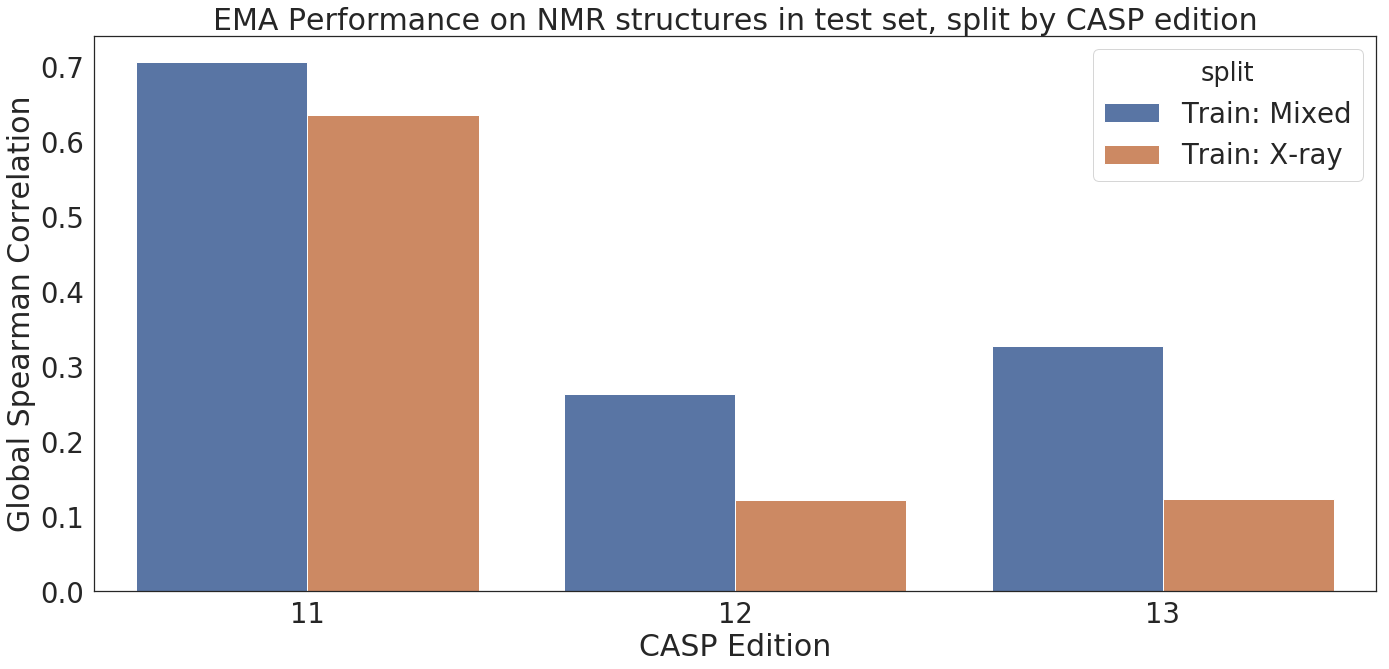

In [27]:
sns.set(style='white', font_scale=2.5)
plt.figure(figsize=(20,10))
sns.barplot('casp', 'pred', hue='split', data=nmr_by_casp)
plt.xlabel('CASP Edition')
plt.ylabel('Global Spearman Correlation')
plt.title('EMA Performance on NMR structures in test set, split by CASP edition')
plt.tight_layout()
plt.savefig('../figures/task2_nmr_by_casp.png', dpi=300)

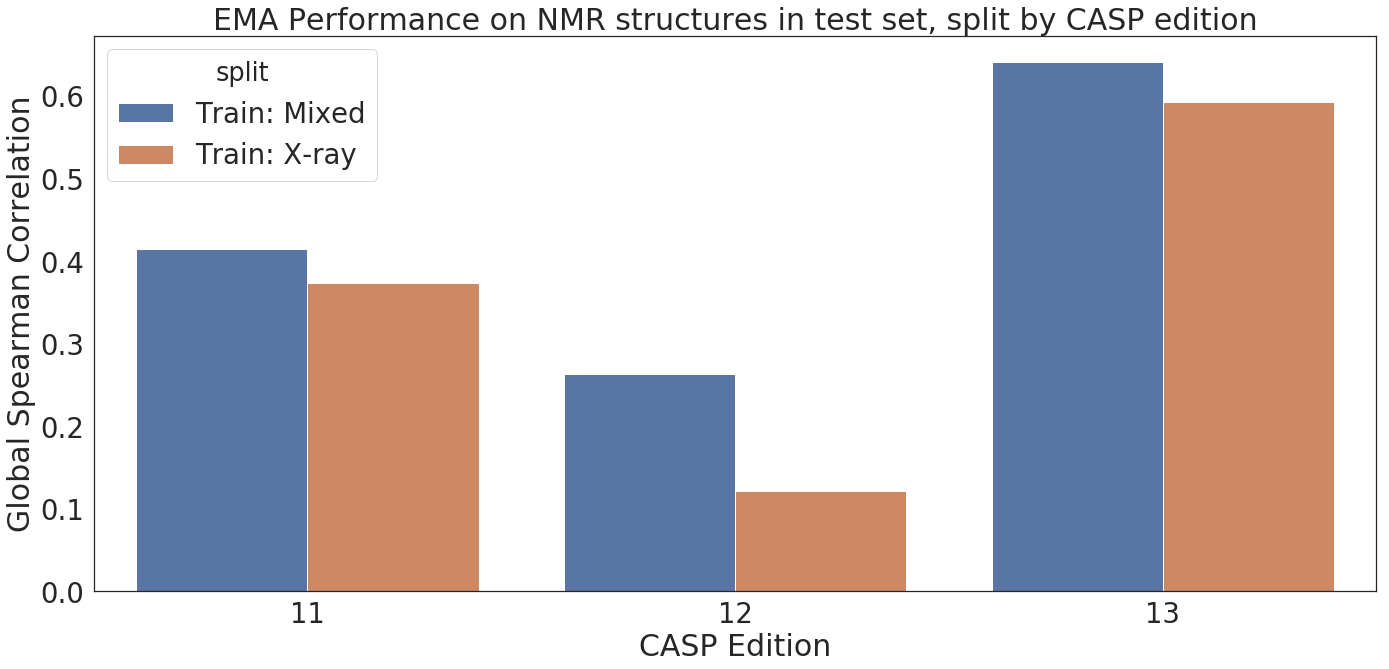

In [28]:
sns.set(style='white', font_scale=2.5)
plt.figure(figsize=(20,10))
sns.barplot('casp', 'pred', hue='split', data=nmr_by_casp_tgt)
plt.xlabel('CASP Edition')
plt.ylabel('Global Spearman Correlation')
plt.title('EMA Performance on NMR structures in test set, split by CASP edition')
plt.tight_layout()
plt.savefig('../figures/task2_nmr_by_casp_target.png', dpi=300)

In [29]:
from scipy.stats import norm

def compute_pearson_pval(cor1, cor2, n):
    fisher1 = 0.5*np.log((1+cor1)/(1-cor1))
    fisher2 = 0.5*np.log((1+cor2)/(1-cor2))
    sd = np.sqrt(1.0/(n-3))
    pval = 2*(1-norm.cdf(np.abs(fisher1-fisher2), scale=sd))
    return pval

In [30]:
em_all, nmr_all, xray_all, em_x, nmr_x, xray_x = pearson_global
n_hypotheses = 3
print('P-values for global pearson correlation between Mixed and X-ray only training sets')
print('X-ray:', compute_pearson_pval(xray_all, xray_x, n_xray)*3)
print('NMR:', compute_pearson_pval(nmr_all, nmr_x, n_nmr)*3)
print('EM:', compute_pearson_pval(em_all, em_x, n_em)*3)

P-values for global pearson correlation between Mixed and X-ray only training sets
X-ray: 0.0
NMR: 0.0
EM: 0.00031176105855035274


In [31]:
np.finfo(float).precision

15

In [32]:
spearman_target = all_res.groupby(['split', 'method','target'])[['true', 'pred']].corr('spearman').iloc[0::2,-1].groupby(['split', 'method']).mean()
spearman_target

split         method             
Train: Mixed  ELECTRON MICROSCOPY    0.438372
              SOLUTION NMR           0.452370
              X-RAY DIFFRACTION      0.642852
Train: X-ray  ELECTRON MICROSCOPY    0.296704
              SOLUTION NMR           0.396843
              X-RAY DIFFRACTION      0.583083
Name: pred, dtype: float64

In [33]:
pearson_target = all_res.groupby(['target', 'split'])[['true', 'pred']].corr('pearson').iloc[0::2,-1]

In [36]:
for target, c1, c2, n in zip(all_res.groupby('target').count().iloc[:,0].index.tolist(), pearson_target[0::2].tolist(), pearson_target[1::2].tolist(), all_res.groupby('target').count().iloc[:,0].tolist()):
    pval = compute_pearson_pval(c1, c2, n)*n_targets
    print(target, np.round(pval,4))#, pval<0.1, pval<0.05, pval<0.01)

T0769 6.0516
T0773 2.4567
T0853 23.268
T0855 19.9525
T0857 3.1693
T0865 0.041
T0902 0.1559
T0918 3.6242
T0950 19.3462
T0951 0.6405
T0953s1 1.8857
T0953s2 3.5739
T0954 7.5116
T0955 0.0041
T0957s1 15.4739
T0957s2 0.914
T0958 0.0424
T0960 0.0006
T0963 0.1484
T0966 0.0
T0968s1 12.3549
T0968s2 11.3608
T1003 0.0043
T1005 0.6508
T1008 11.1116
T1009 0.0348
T1011 0.0009
T1016 20.6921


<Figure size 1440x720 with 0 Axes>

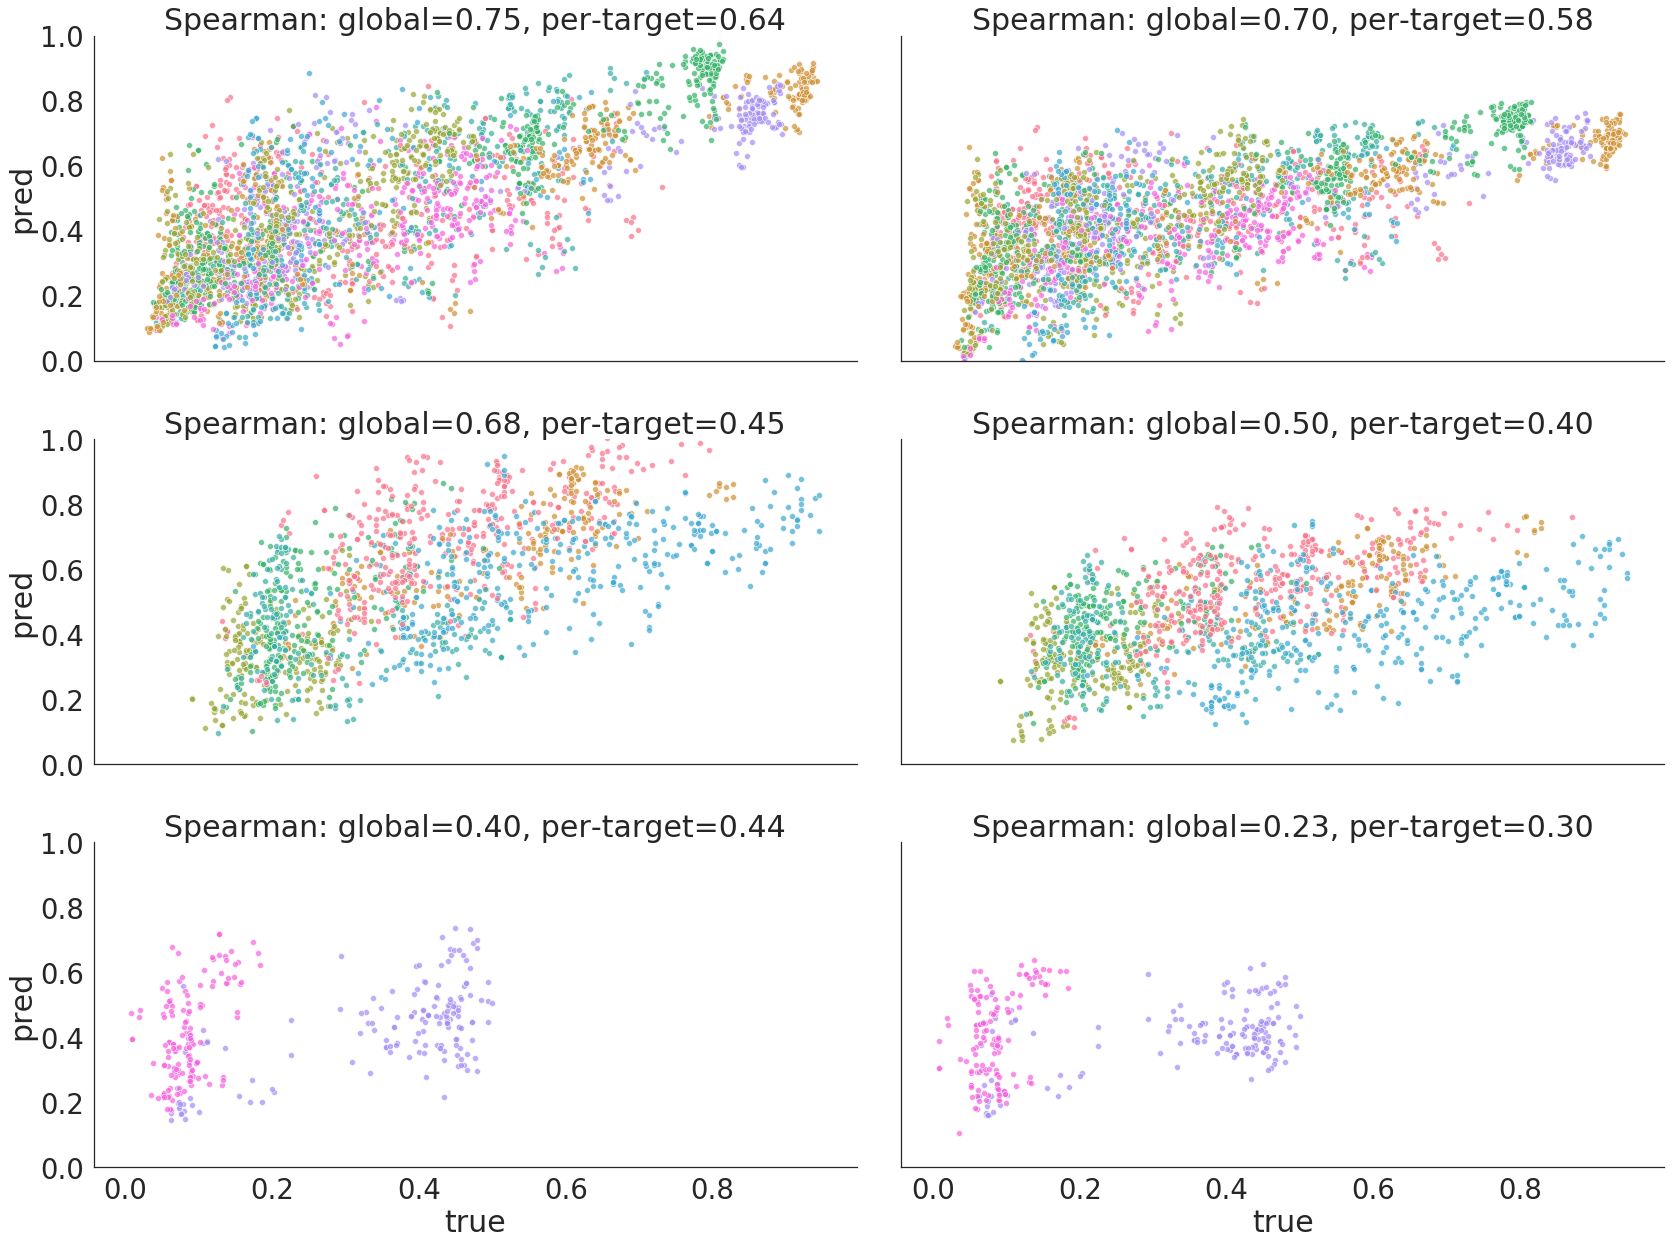

In [45]:
sns.set(style='white', font_scale=2.5)
plt.figure(figsize=(20,10))
g = sns.FacetGrid(all_res, row='method', col='split', height=6, aspect=2, hue='target', palette=sns.color_palette('husl', 8), row_order=['X-RAY DIFFRACTION', 'SOLUTION NMR', 'ELECTRON MICROSCOPY'], col_order=['Train: Mixed', 'Train: X-ray'])
g.map(sns.scatterplot, "true", "pred", alpha=.7)
plt.ylim(0.0, 1.0)
axes = g.axes.flatten()
axes[0].set_title("Spearman: global=0.75, per-target=0.64")
axes[1].set_title("Spearman: global=0.70, per-target=0.58")
axes[2].set_title("Spearman: global=0.68, per-target=0.45")
axes[3].set_title("Spearman: global=0.50, per-target=0.40")
axes[4].set_title("Spearman: global=0.40, per-target=0.44")
axes[5].set_title("Spearman: global=0.23, per-target=0.30")
plt.tight_layout()
plt.savefig('../figures/task2_scatters.png', dpi=300)

In [46]:
df_natives_pdb = pd.read_csv('natives_pdb.csv')
df_natives_pdb.head()

,casp_ed,chains,residues,atoms,target_id,length,pdb_id,EXPERIMENT TYPE
0,8,3,774,4493,T0388,174,3cyn,X-RAY DIFFRACTION
1,8,2,359,2123,T0389,153,2vsw,X-RAY DIFFRACTION
2,8,3,380,2584,T0390,182,3czu,X-RAY DIFFRACTION
3,8,1,186,1155,T0391,157,3d89,X-RAY DIFFRACTION
4,8,2,294,1631,T0392,109,2vsv,X-RAY DIFFRACTION


In [47]:
target_to_length = dict(zip(df_natives_pdb.target_id.tolist(), df_natives_pdb.residues.tolist()))

In [48]:
df_by_target = all_res.groupby(['split', 'method','target'])[['true', 'pred']].corr('spearman').iloc[0::2,-1].reset_index()

In [49]:
df_by_target = pd.merge(df_by_target, df_natives_pdb, left_on='target', right_on='target_id')

In [50]:
df_by_target = df_by_target.rename(columns={'pred': 'spearman'})
df_by_target.head()

,split,method,target,level_3,spearman,casp_ed,chains,residues,atoms,target_id,length,pdb_id,EXPERIMENT TYPE
0,Train: Mixed,ELECTRON MICROSCOPY,T0902,true,0.500788,12,7,2076,15232,T0902,315,3jb5,ELECTRON MICROSCOPY
1,Train: X-ray,ELECTRON MICROSCOPY,T0902,true,0.319472,12,7,2076,15232,T0902,315,3jb5,ELECTRON MICROSCOPY
2,Train: Mixed,ELECTRON MICROSCOPY,T0918,true,0.375956,12,6,2496,16902,T0918,546,5uvn,ELECTRON MICROSCOPY
3,Train: X-ray,ELECTRON MICROSCOPY,T0918,true,0.273936,12,6,2496,16902,T0918,546,5uvn,ELECTRON MICROSCOPY
4,Train: Mixed,SOLUTION NMR,T0769,true,0.564198,11,20,2240,37140,T0769,112,2mq8,SOLUTION NMR


In [51]:
df_by_target['target_len'] = df_by_target['target_id'] + ' (' + df_by_target['length'].astype(str) + ' aa)'

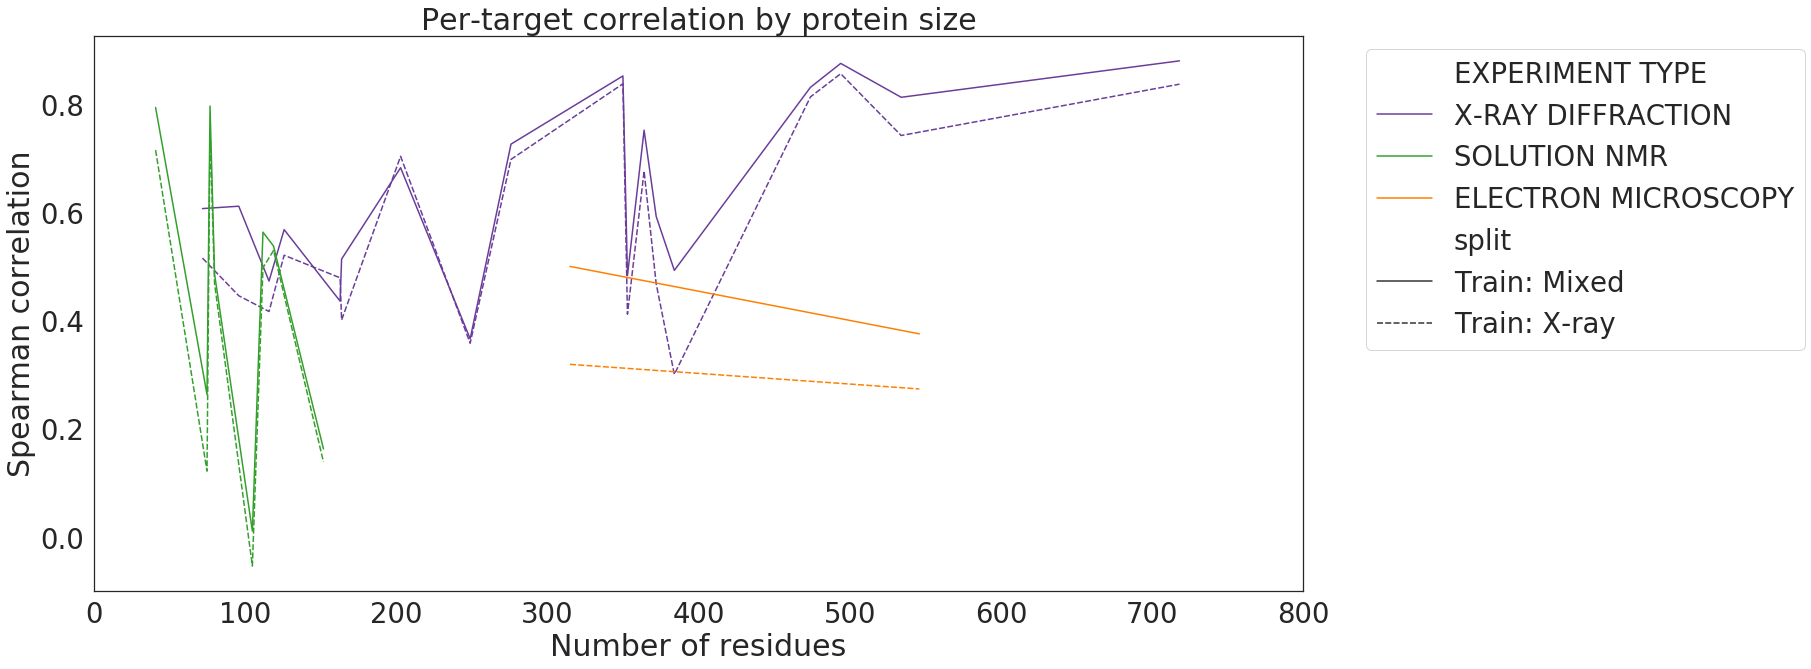

In [52]:
sns.set(style='white', font_scale=2.5)
plt.figure(figsize=(26,10))
sns.lineplot(x='length', y='spearman', hue='EXPERIMENT TYPE', data=df_by_target, style='split', hue_order=['X-RAY DIFFRACTION', 'SOLUTION NMR', 'ELECTRON MICROSCOPY'], palette=[sns.color_palette('Paired')[9],sns.color_palette('Paired')[3],sns.color_palette('Paired')[7]])
plt.title('Per-target correlation by protein size')
plt.ylabel('Spearman correlation')
plt.xlabel('Number of residues')
plt.xlim(0,800)
plt.legend(bbox_to_anchor=(1.04,1), loc=2)
plt.tight_layout()
plt.savefig('../figures/task2_spearman_by_length.png', dpi=300)

In [53]:
len_order =  list(df_by_target.sort_values('length')['target_len'].unique())

In [54]:
color_map = dict(zip(['X-RAY DIFFRACTION', 'SOLUTION NMR', 'ELECTRON MICROSCOPY'], [sns.color_palette('Paired')[9],sns.color_palette('Paired')[3],sns.color_palette('Paired')[7]]))

In [55]:
target_colors = {x:color_map[target_method_dict[x.split()[0]]] for x in len_order}

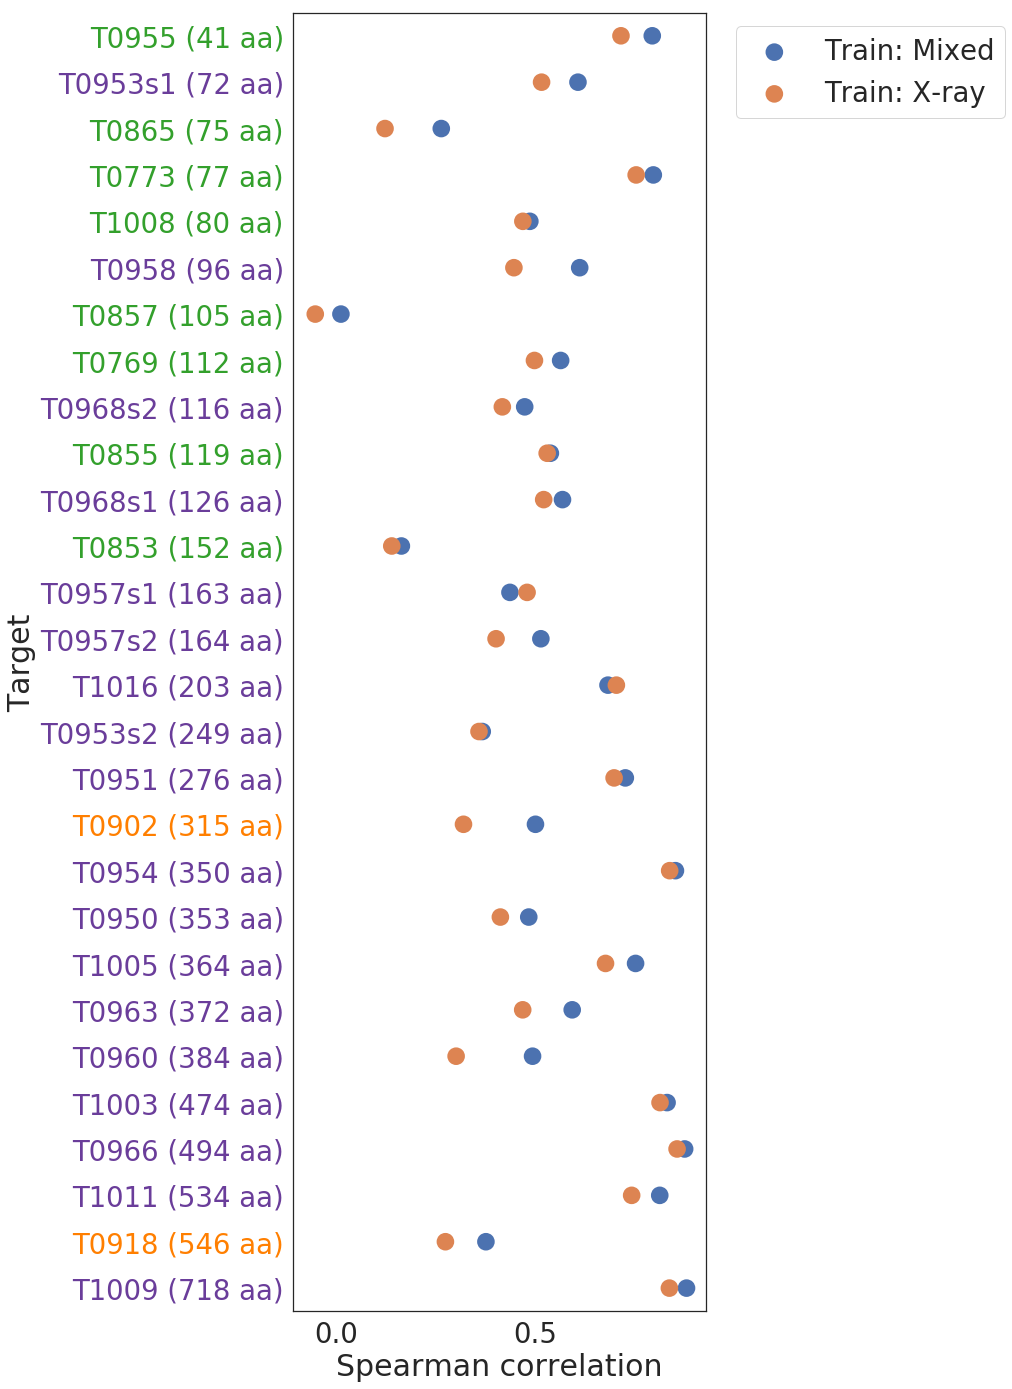

In [57]:
sns.set(style='white', font_scale=2.5)
plt.figure(figsize=(15,20))
sns.pointplot(x='spearman', y='target_len', orient='h', data=df_by_target, hue='split', hue_order=['Train: Mixed', 'Train: X-ray'], join=False, order=len_order, scale=2)
plt.xlabel('Spearman correlation')
plt.ylabel('Target')
[i.set_color(target_colors[i.get_text()]) for i in plt.gca().get_yticklabels()]
plt.legend(bbox_to_anchor=(1.04,1), loc=2)
plt.tight_layout()
plt.savefig('../figures/task2_spearman_by_length_point.png', dpi=300)